Epoch 1/20
75/75 [==============================] - 112s 1s/step - loss: 0.0930 - accuracy: 0.5844 - val_loss: 0.0303 - val_accuracy: 0.1735 - lr: 1.0000e-04
Epoch 2/20
75/75 [==============================] - 115s 2s/step - loss: 0.0464 - accuracy: 0.5591 - val_loss: 0.0390 - val_accuracy: 0.3609 - lr: 1.0000e-04
Epoch 3/20
75/75 [==============================] - 114s 2s/step - loss: 0.0419 - accuracy: 0.5666 - val_loss: 0.0323 - val_accuracy: 0.3633 - lr: 1.0000e-04
Epoch 4/20
75/75 [==============================] - 112s 1s/step - loss: 0.0360 - accuracy: 0.5652 - val_loss: 0.0268 - val_accuracy: 0.3583 - lr: 1.0000e-04
Epoch 5/20
75/75 [==============================] - 114s 2s/step - loss: 0.0360 - accuracy: 0.5545 - val_loss: 0.0266 - val_accuracy: 0.4474 - lr: 1.0000e-04
Epoch 6/20
75/75 [==============================] - 117s 2s/step - loss: 0.0334 - accuracy: 0.5960 - val_loss: 0.0274 - val_accuracy: 0.4330 - lr: 1.0000e-04
Epoch 7/20
75/75 [==============================] - 

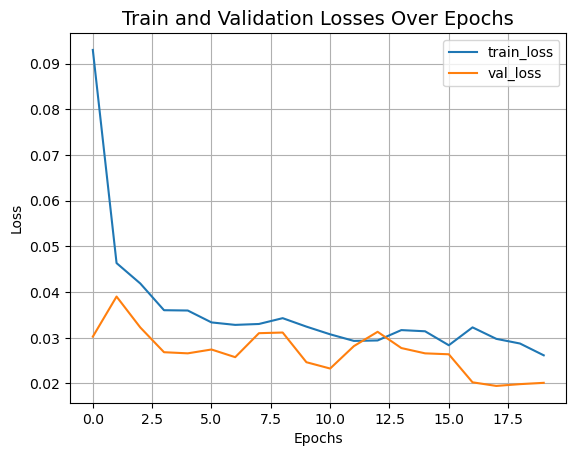

1/1 [==============================] - 1s 1s/step


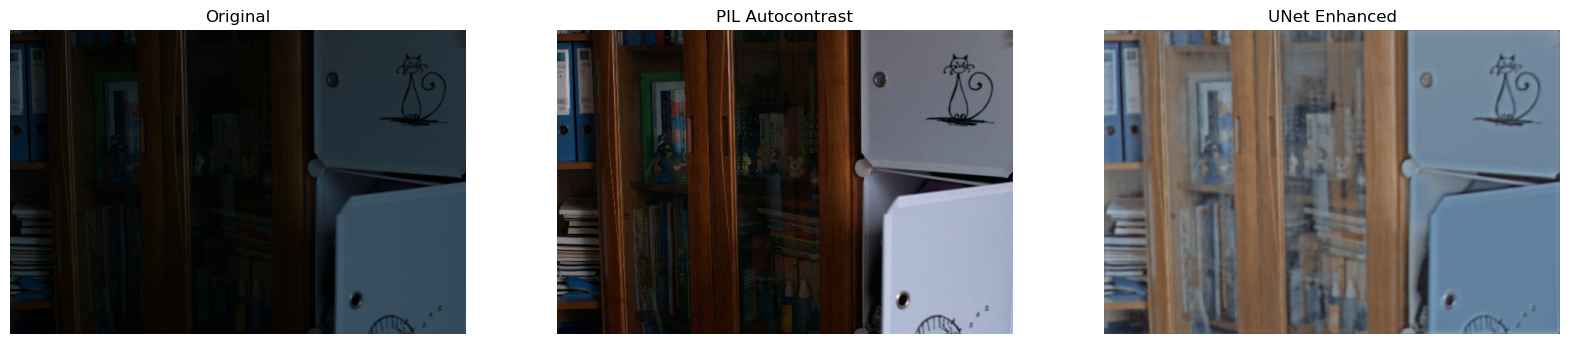

1/1 [==============================] - 1s 974ms/step


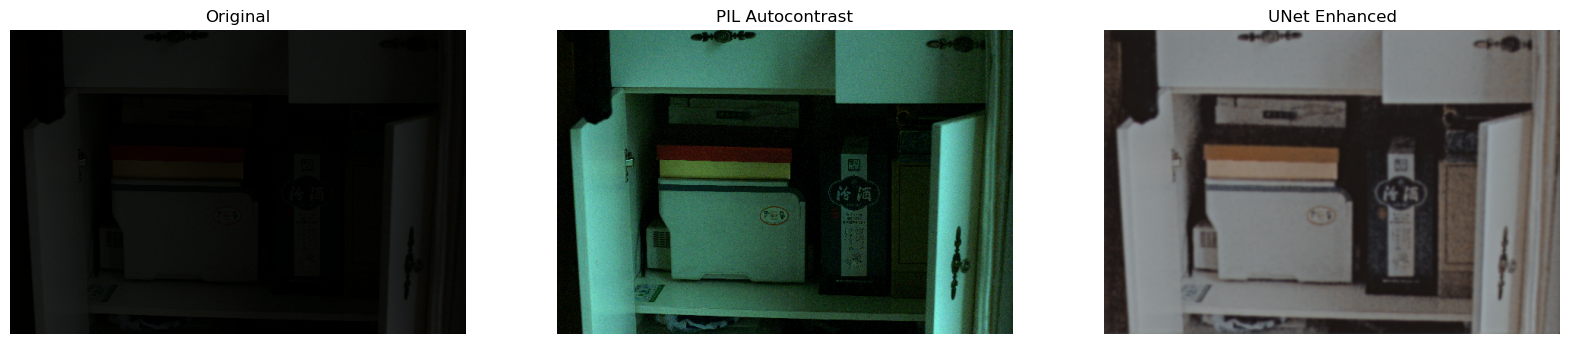

1/1 [==============================] - 1s 971ms/step


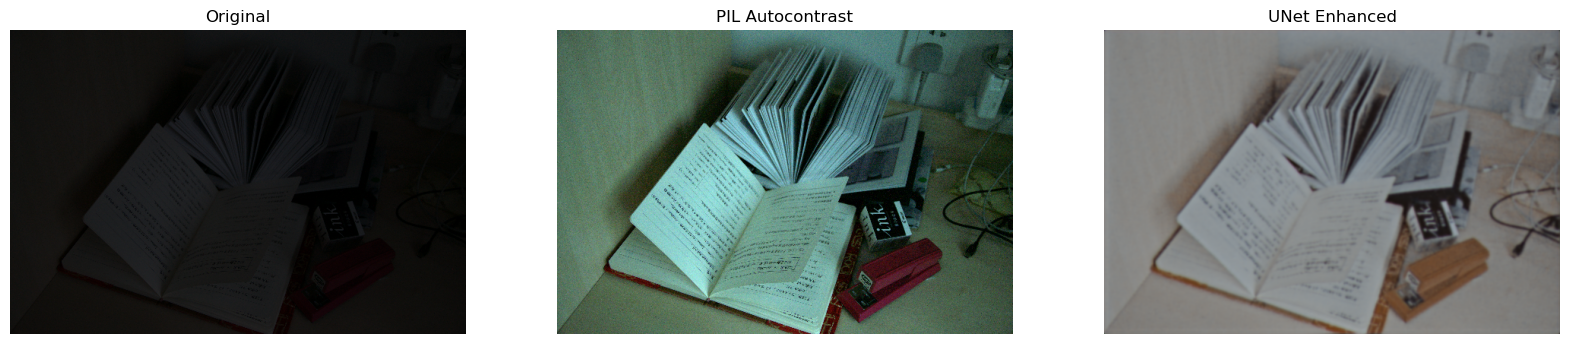

1/1 [==============================] - 1s 966ms/step


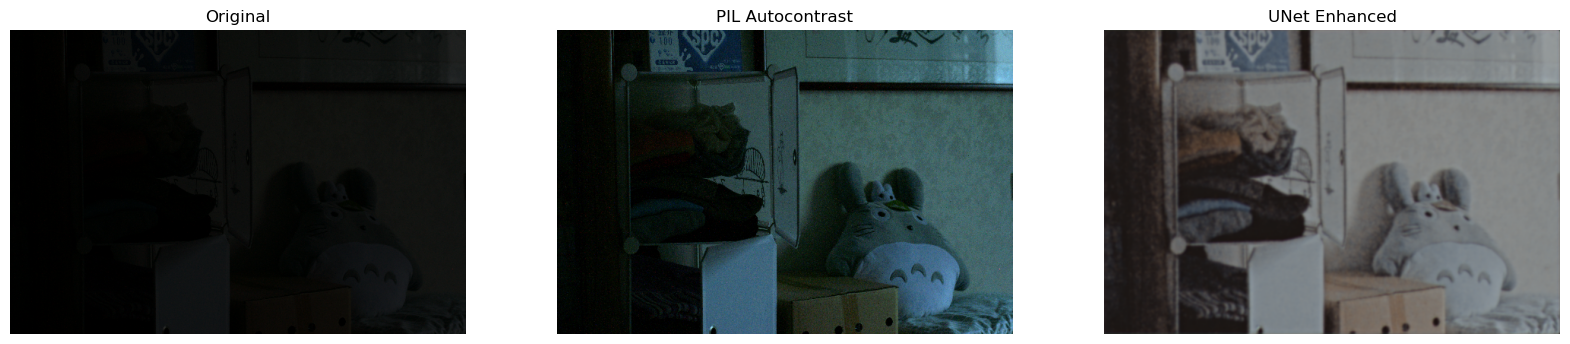

1/1 [==============================] - 1s 967ms/step


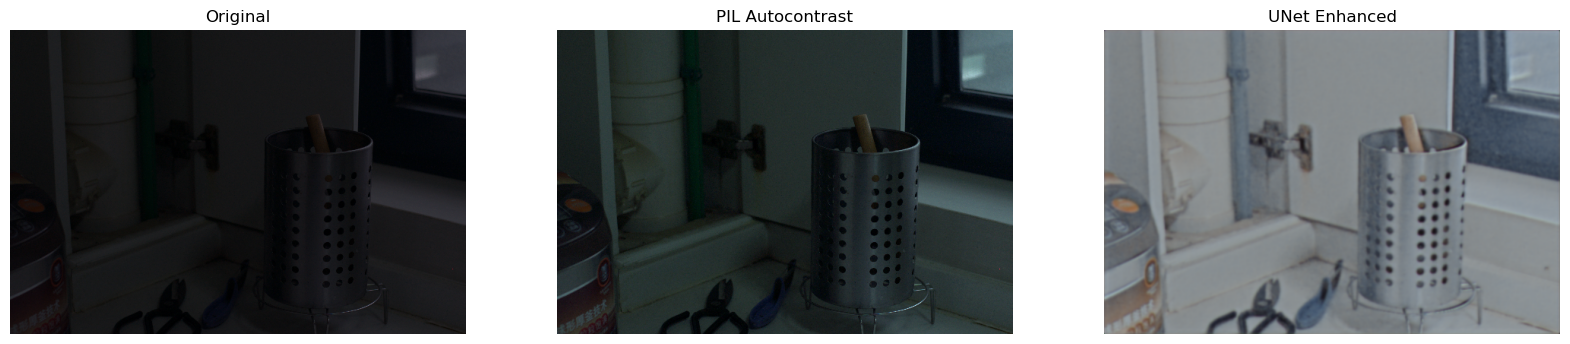

1/1 [==============================] - 1s 963ms/step


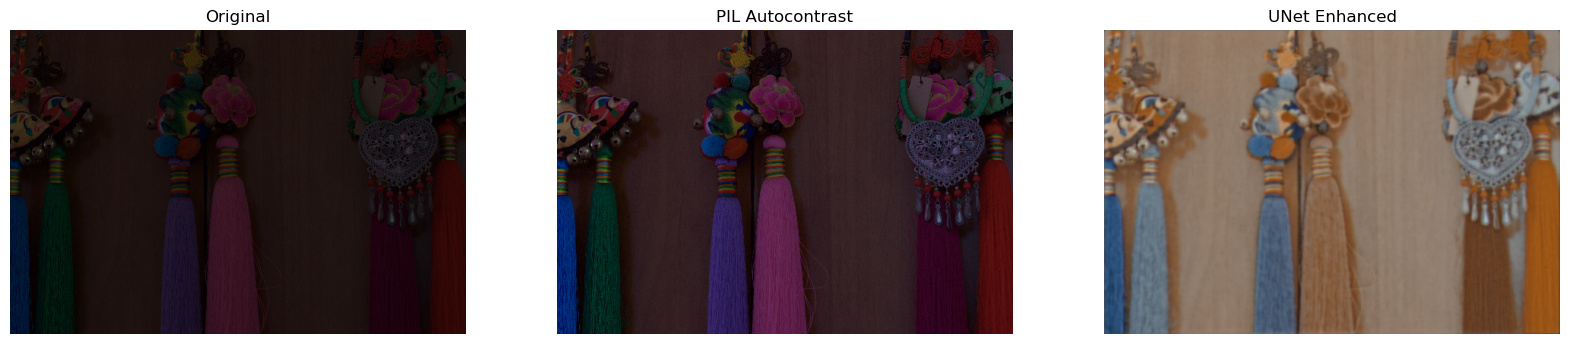

In [38]:
import os
import cv2
import random
import numpy as np
from glob import glob
from PIL import Image, ImageOps
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

tf.random.set_seed(2)
np.random.seed(1)
random.seed(10)

IMAGE_SIZE = 256
BATCH_SIZE = 4
MAX_TRAIN_IMAGES = 300


def read_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image.set_shape([None, None, 3])
    image = tf.cast(image, dtype=tf.float32) / 255.0
    return image


def random_crop(low_image, enhanced_image):
    low_image_shape = tf.shape(low_image)[:2]
    low_w = tf.random.uniform(
        shape=(), maxval=low_image_shape[1] - IMAGE_SIZE + 1, dtype=tf.int32
    )
    low_h = tf.random.uniform(
        shape=(), maxval=low_image_shape[0] - IMAGE_SIZE + 1, dtype=tf.int32
    )
    enhanced_w = low_w
    enhanced_h = low_h
    low_image_cropped = low_image[
        low_h : low_h + IMAGE_SIZE, low_w : low_w + IMAGE_SIZE
    ]
    enhanced_image_cropped = enhanced_image[
        enhanced_h : enhanced_h + IMAGE_SIZE, enhanced_w : enhanced_w + IMAGE_SIZE
    ]
    return low_image_cropped, enhanced_image_cropped


def load_data(low_light_image_path, enhanced_image_path):
    low_light_image = read_image(low_light_image_path)
    enhanced_image = read_image(enhanced_image_path)
    low_light_image, enhanced_image = random_crop(low_light_image, enhanced_image)
    return low_light_image, enhanced_image


def get_dataset(low_light_images, enhanced_images):
    dataset = tf.data.Dataset.from_tensor_slices((low_light_images, enhanced_images))
    dataset = dataset.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    return dataset


def unet_model():
    inputs = keras.Input(shape=[None, None, 3])

    # Encoder
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)

    # Bottleneck
    conv4 = layers.Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = layers.Conv2D(512, 3, activation='relu', padding='same')(conv4)

    # Decoder
    up5 = layers.UpSampling2D((2, 2))(conv4)
    concat5 = layers.concatenate([up5, conv3], axis=-1)
    conv5 = layers.Conv2D(256, 3, activation='relu', padding='same')(concat5)
    conv5 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv5)

    up6 = layers.UpSampling2D((2, 2))(conv5)
    concat6 = layers.concatenate([up6, conv2], axis=-1)
    conv6 = layers.Conv2D(128, 3, activation='relu', padding='same')(concat6)
    conv6 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv6)

    up7 = layers.UpSampling2D((2, 2))(conv6)
    concat7 = layers.concatenate([up7, conv1], axis=-1)
    conv7 = layers.Conv2D(64, 3, activation='relu', padding='same')(concat7)
    conv7 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv7)

    # Output
    outputs = layers.Conv2D(3, 3, activation='linear', padding='same')(conv7)

    model = keras.Model(inputs, outputs)
    return model


def plot_results(images, titles, figure_size=(12, 12)):
    fig = plt.figure(figsize=figure_size)
    for i in range(len(images)):
        fig.add_subplot(1, len(images), i + 1).set_title(titles[i])
        _ = plt.imshow(images[i])
        plt.axis("off")
    plt.show()


def infer(original_image):
    image = keras.utils.img_to_array(original_image)
    image = image.astype("float32") / 255.0
    image = np.expand_dims(image, axis=0)
    output = unet.predict(image)
    output_image = output[0] * 255.0
    output_image = output_image.clip(0, 255)
    output_image = output_image.reshape(
        (np.shape(output_image)[0], np.shape(output_image)[1], 3)
    )
    output_image = Image.fromarray(np.uint8(output_image))
    original_image = Image.fromarray(np.uint8(original_image))
    return output_image


train_low_light_images = sorted(glob("C:/Users/heman/domain project/lol_dataset/our485/low/images/*"))[:MAX_TRAIN_IMAGES]
train_enhanced_images = sorted(glob("C:/Users/heman/domain project/lol_dataset/our485/high/images/*"))[:MAX_TRAIN_IMAGES]

val_low_light_images = sorted(glob("C:/Users/heman/domain project/lol_dataset/our485/low/images/*"))[MAX_TRAIN_IMAGES:]
val_enhanced_images = sorted(glob("C:/Users/heman/domain project/lol_dataset/our485/high/images/*"))[MAX_TRAIN_IMAGES:]

test_low_light_images = sorted(glob("C:/Users/heman/domain project/lol_dataset/eval15/low/images/*"))
test_enhanced_images = sorted(glob("C:/Users/heman/domain project/lol_dataset/eval15/high/images/*"))

train_dataset = get_dataset(train_low_light_images, train_enhanced_images)
val_dataset = get_dataset(val_low_light_images, val_enhanced_images)

unet = unet_model()

optimizer = keras.optimizers.Adam(learning_rate=1e-4)
unet.compile(optimizer=optimizer, loss='mse', metrics=['accuracy'])

history = unet.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
    callbacks=[
        keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss",
            factor=0.5,
            patience=5,
            verbose=1,
            min_delta=1e-7,
            mode="min",
        )
    ],
)

plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Validation Losses Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.show()

# Testing the model
for low_light_image in random.sample(test_low_light_images, 6):
    original_image = Image.open(low_light_image)
    enhanced_image = infer(original_image)
    plot_results(
        [original_image, ImageOps.autocontrast(original_image), enhanced_image],
        ["Original", "PIL Autocontrast", "UNet Enhanced"],
        (20, 12),
    )


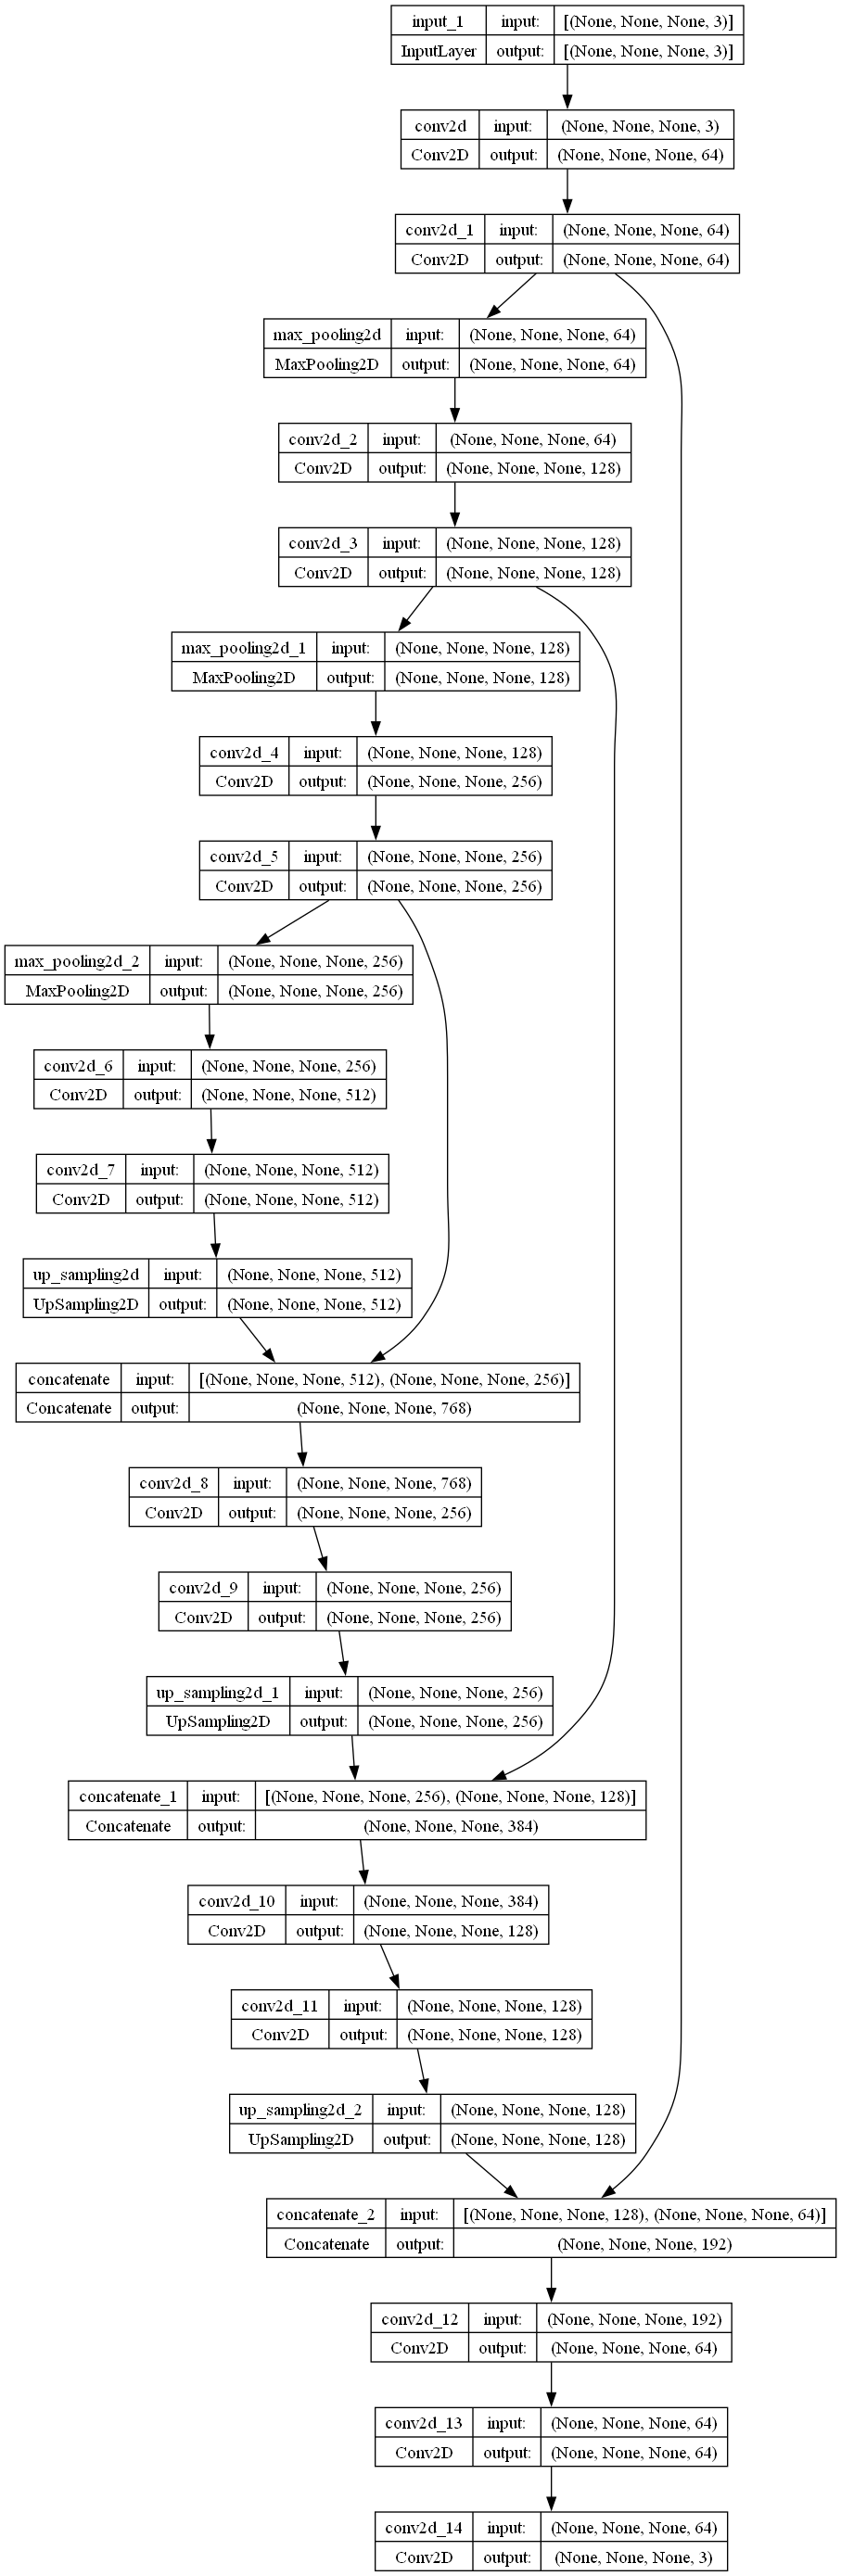

In [40]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image

plot_model(unet, to_file='model_.png', show_shapes=True, show_layer_names=True)
Image(retina=True, filename='model_.png')


In [2]:
save_path = "C:/Users/heman/domain project/"
if not os.path.exists(save_path):
    os.makedirs(save_path)

model_save_path = os.path.join(save_path, "unet_model_128.h5")
unet.save(model_save_path)
print(f"Model saved to: {model_save_path}")

C:\Users\heman\anaconda3\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved to: C:/Users/heman/domain project/unet_model_128.h5
